# CQR using LGBM algorithm on **Sparse** dataset.

In [ ]:
%matplotlib inline

In [4]:
import warnings

from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
from matplotlib.offsetbox import (TextArea, AnnotationBbox)
from matplotlib.ticker import FormatStrFormatter
import numpy as np
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV, train_test_split, KFold
from scipy.stats import randint, uniform
from typing import Tuple, Dict

from mapie._typing import ArrayLike, NDArray
from mapie.metrics import (
    regression_coverage_score,
    regression_mean_width_score
    )
from mapie.regression import MapieRegressor
from mapie.subsample import Subsample
from mapie.quantile_regression import MapieQuantileRegressor


random_state = 23
rng = np.random.default_rng(random_state)
round_to = 3

warnings.filterwarnings("ignore")

In [5]:
from libraries import *

2022-09-02 14:01:45.525650: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-02 14:01:45.525680: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Load Data

In [9]:
#load data
data = pd.read_pickle('../../../Data/Sparse_data.pkl')

# Split data traning and target.
y = data['y']
X = data.drop(["y"], axis=1)

#Split data into training and testing sets
TEST_SIZE = 0.1 #define test size 0.1 = 10% of the data
CALIB_SIZE = 0.1


X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size)
X_train, X_calib, y_train, y_calib = train_test_split(X_train, y_train, test_size = CALIB_SIZE)

# data shapes summary
print(f"\nTraining Data : {X_train.shape}")
print(f"Testing Data  : {X_test.shape}\n")
print(f"Calibration Data : {X_calib.shape}")


Training Data : (7935, 753)
Testing Data  : (980, 753)

Calibration Data : (882, 753)


## 2. Optimizing estimator LGBM
Optimization of the `LGBMRegressor` using `RandomizedSearchCV` to find the
optimal model to predict the house prices.



In [29]:
estimator = LGBMRegressor(
    objective='quantile',
    alpha=0.5,
    random_state=random_state
)
params_distributions = dict(
    num_leaves=randint(low=10, high=50),
    max_depth=randint(low=3, high=20),
    n_estimators=randint(low=50, high=300),
    learning_rate=uniform()
)
optim_model = RandomizedSearchCV(
    estimator,
    param_distributions=params_distributions,
    n_jobs=-1,
    n_iter=150,
    cv=KFold(n_splits=5),
    verbose=-1
)
optim_model.fit(X_train, y_train)
estimator = estimator.set_params(**optim_model.best_params_)

## Use CQR to get Quantiles

In [30]:
STRATEGIES = {
    "cqr": {"method": "quantile", "cv": "split", "alpha": 0.1},
}
y_pred, y_pis = {}, {}
y_pred_train, y_pis_train = {}, {}

coverage, width = {}, {}

for strategy, params in STRATEGIES.items():
    if strategy == "cqr":
        mapie = MapieQuantileRegressor(estimator, **params)  # type: ignore
        mapie.fit(X_train, y_train, X_calib=X_calib, y_calib=y_calib)
        y_pred[strategy], y_pis[strategy] = mapie.predict(X_test)
        y_pred_train[strategy], y_pis_train[strategy] = mapie.predict(X_train)
    else:
        mapie = MapieRegressor(estimator, **params)  # type: ignore
        mapie.fit(X_train, y_train)
        y_pred[strategy], y_pis[strategy] = mapie.predict(X_test, alpha=0.2)
    
    coverage[strategy] = np.round(regression_coverage_score(
        y_test,
        y_pis[strategy][:, 0, 0],
        y_pis[strategy][:, 1, 0]
        ), round_to)
    width[strategy] = np.round(regression_mean_width_score(
        y_pis[strategy][:, 0, 0],
        y_pis[strategy][:, 1, 0]
        ), round_to)

## Retrive the quantiles. 

In [31]:
pred_test = y_pred['cqr']
lower_test = y_pis['cqr'][:, 0, 0]
upper_test = y_pis['cqr'][:, 1, 0]
mediane_test = mapie.estimators_[2].predict(X_test)

In [32]:
pred_train = y_pred_train['cqr']
lower_train = y_pis_train['cqr'][:, 0, 0]
upper_train = y_pis_train['cqr'][:, 1, 0]
mediane_train = mapie.estimators_[2].predict(X_train)

<AxesSubplot:xlabel='Residual error', ylabel='Density'>

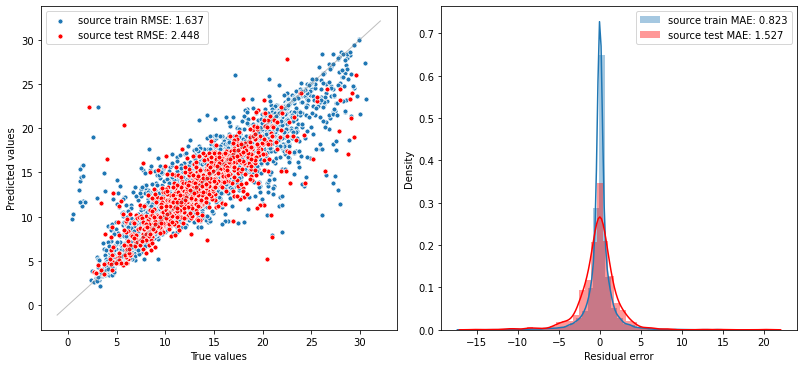

In [33]:
fig = plt.figure(constrained_layout=True, figsize=(16, 14))
gs = fig.add_gridspec(3, 3)

ax1 = fig.add_subplot(gs[0, 0]); ax2 = fig.add_subplot(gs[0, 1]); 

plot_adequation(y_train, pred_train, label='source train', ax=ax1, score='RMSE')
plot_adequation(y_test, pred_test, label='source test', ax=ax1, plot_line=False, score='RMSE', color='red')



plot_residuals(y_train, pred_train, kind='hist', label='source train', ax=ax2, score='MAE')
plot_residuals(y_test, pred_test, kind='hist', label='source test', ax=ax2, score='MAE', color='red')

<AxesSubplot:xlabel='Confidence Indice', ylabel='Residual error (Pred - True)'>

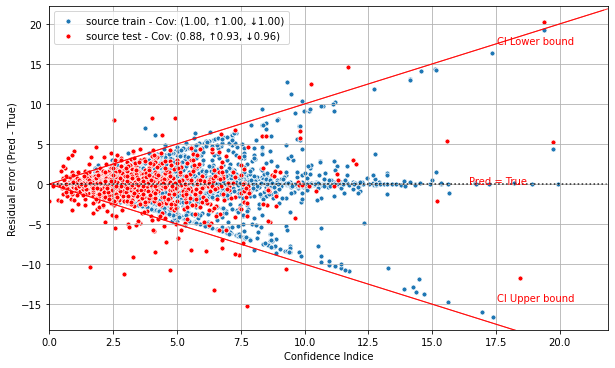

In [34]:
fig = plt.figure(constrained_layout=True, figsize=(24, 14))
gs = fig.add_gridspec(3, 3)

ax1 = fig.add_subplot(gs[0, 0])
plt.grid(True)

plot_confidence_v2(y_train,pred_train , lower_train,  upper_train, ax=ax1, label='source train')
plot_confidence_v2(y_test,pred_test, lower_test,  upper_test, ax=ax1, color='red', label='source test')

## Approximate the mean and the variance

In [35]:
p0_05 = lower_test.copy()
p0_5 = mediane_test.copy()
p0_95 = upper_test.copy()

In [36]:
def pearson_tukey(p0_05, p0_5, p0_95):
    mu = 0.63*p0_5 + 0.185*(p0_05+p0_95)
    std = 0.63*(p0_5-mu)**2+0.185*((p0_05-mu)**2 + (p0_95-mu)**2)
    return mu, std

In [37]:
mu, stds = pearson_tukey(p0_05, p0_5, p0_95)

## Results

<AxesSubplot:title={'center':'Average Calibration'}, xlabel='Predicted Proportion in Interval', ylabel='Observed Proportion in Interval'>

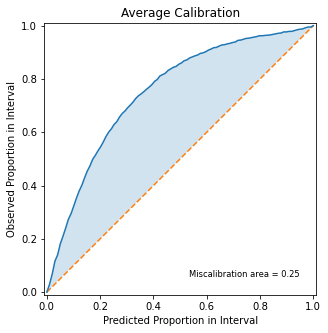

In [38]:
uct.viz.plot_calibration(np.array(pred_test),  np.array(stds), np.array(y_test))

In [39]:
all_metrics = uct.get_all_metrics(np.array(pred_test),np.array(stds), np.array(y_test))

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics
 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:01<00:00,  7.17it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:01<00:00,  6.15it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           1.527
  RMSE          2.448
  MDAE          0.926
  MARPD         12.051
  R2            0.705
  Correlation   0.841
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.278
  Mean-absolute Calibration Error       0.249
  Miscalibration Area                   0.251
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.285
     Group Size: 0.56 -- Calibration Error: 0.259
     Group Size: 1.00 -- Calibration Error: 0.249
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.314
     Group Size: 0.56 -- Calibration Error: 0.288
     Group Size: 1.00 -- Calibration Error: 0.278
===============

## Re-Calibration

In [40]:
recalibrator = uct.recalibration.get_std_recalibrator(np.array(pred_test), np.array(stds), np.array(y_test), criterion='ma_cal')
new_stds = recalibrator(np.array(stds))

<AxesSubplot:title={'center':'Average Calibration'}, xlabel='Predicted Proportion in Interval', ylabel='Observed Proportion in Interval'>

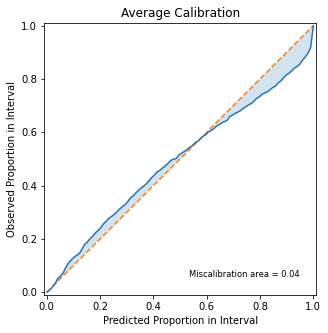

In [41]:
uct.viz.plot_calibration(np.array(pred_test),  np.array(new_stds), np.array(y_test))

In [42]:
all_metrics_calib = uct.get_all_metrics(np.array(pred_test),np.array(new_stds), np.array(y_test))

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics
 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:01<00:00,  5.97it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:01<00:00,  7.02it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           1.527
  RMSE          2.448
  MDAE          0.926
  MARPD         12.051
  R2            0.705
  Correlation   0.841
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.047
  Mean-absolute Calibration Error       0.039
  Miscalibration Area                   0.039
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.071
     Group Size: 0.56 -- Calibration Error: 0.048
     Group Size: 1.00 -- Calibration Error: 0.039
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.082
     Group Size: 0.56 -- Calibration Error: 0.054
     Group Size: 1.00 -- Calibration Error: 0.047
===============